In [26]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH222

# Studying the solvation shell of ions via Molecular Dynamics Simulations

In this computational experiment you will use **molecular dynamics simulations** to investigate the solvation shell of ions at the atomistic level. For this computer experiment the ions and the solvent particles will be represented by relatively simple models (more on that later), and you will examine how the size of the cation and the temperature effect the structure of the solvation shell.

You will use the Python-based Jupyter Notebook framework, leveraging Statistical Mechanics to compute structural features of this system.

This notebook outlines how to set up the MD simulation using the HOOMD-blue simulation package, and some tips on using the Atomic Simulation Environment (ASE) for handling atomic configurations.

You can find further help, features and options on the Manual pages:  
[HOOMD-blue page](https://hoomd-blue.readthedocs.io/en/stable/index.html)  
[ASE page](https://wiki.fysik.dtu.dk/ase/index.html)

<div class=warn>
Tasks, where you need to edit the code cells will be shown in similar "blue boxes".
<div/>

**IMPORTANT!!!** Use **Google Chrome** to work on the notebook instead of using Microsoft Explorer. The latter handles the visualisation package incorrectly.

## Content of this notebook

#### Setting up the simulation

1. Import necessary libraries and initialise HOOMD
2. Set up the system - initial structure, number of atoms
3. Define interaction between particles - binary Lennard-Jones
4. Set up the MD simulation and the ensemble - set the integrator, temperature, pressure
5. Set the output format - output file and logged quantities

#### Performing the simulation

6. Perform the simulation - hoomd.run()

   Saving the atomic coordinates and visualising the system 

#### Analysing the results

7. Analysing results

## 1. Import necessary libraries and initialise HOOMD

Import the hoomd python package and the md component we will use to perform MD simulations.

In [1]:
import hoomd
import hoomd.md

We need to initialize the execution context to control where HOOMD will execute the simulation. We will run the simulations on the CPU (HOOMD also allows options for GPU, but we won't use them).

In [2]:
hoomd.context.initialize('--mode=cpu');

HOOMD-blue 2.9.3 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 12/16/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


Import some further python packages we will need for analysing and visualising simulations results.

In [3]:
import numpy as np
from matplotlib import pyplot 
import ase # Atomic simulation environment
import ase.io
from ase.visualize import view
#packages necessary to visualise the trajectories
import pytraj as pt 
import nglview as nv

## 2. Create initial configuration

First we need to create the **inital configuration** for the simulation to start from: 

- size of the simulation box
- number of atoms in the system
- position of the atoms (coordinates)

We define our simulation system as the following: we create an initial smaller cell, than we will replicate this cell in each Cartesian direction (3 times) to create our actual simulation box.

The initial small cell is cubic, with box length 8.0 One ion pair is placed within this, with 60 solvent particles. Their coordinates are randomly generated with the condition they are not closer to 1.0 to avoid atomic overlaps. 
(Note: You can define the system only once, thus you can execute the code cell below only once. If you want to experiment with different setups, you need to restart the kernel or initialize the hoomd.context again!)

<div class=warn>
Set the box length and the number of solvents below: </div>

In [4]:
boxL=8.0
N_solvent=60

In [5]:
position=[]
type_name=[]
charge=[]
mass=[]

#Add one cation
position.append([0.0, 0.0, 0.0])
type_name.append('Cation')
charge.append(1.0)
mass.append(1.0)
    
#Add one anion    
position.append([3.0, 3.0, 3.0])
type_name.append('Anion')
charge.append(-1.0)
mass.append(1.0)

#Add solvent particles
for i in range(N_solvent):
    generate_new=True 
    while generate_new: 
        trial=np.random.rand(3)*(boxL-1.0)
        generate_new=False
        for j in range(i+2):
            if (np.linalg.norm(position[j]-trial)<1.0):
                generate_new=True
    position.append(trial)
    type_name.append('Solvent')
    charge.append(0.0)
    mass.append(1.0)
    
#Create the initial cell    
initial_cell = hoomd.lattice.unitcell(N = N_solvent+2, # number of atoms in the initial cell
                a1 = [boxL,0,0],
                a2 = [0,boxL,0],
                a3 = [0,0,boxL], # these define a cubic box of length boxL 
                position = position, # set positions for the two atoms (they should not be placed on top of each other)
                type_name = type_name,
                charge = charge,
                mass = mass,  
                            );

#Using the initial cell as a building block, create a larger cell. This one will be used for the simulation.
system=hoomd.init.create_lattice(initial_cell,n=3) 

notice(2): Group "all" created containing 1674 particles


####  Now it's time to have a look at our system - It's always a good idea to see what we have created! 

HOOMD uses its own format to store the system parameters and a binary file format to save configurations file, which would be difficult to handle without additional separate programs, so we will make use of the Atomic Simulation Environment (ASE) to save configurations and analyse them. The short ``save_config`` function below extracts the simulation box parameters and the atomic coordinates from the hoomd ``system`` we have defined, and creates an atoms object from it. 

**Note:** ASE expects real atomic symbols as atom types, thus e.g. ``Solvent`` will not work. Hence, we will call our particle types S (solvent), C (Cation) and Ar (Anion), this will only effect the visualisation and how you refer to the atoms during the analysis code. 

In [6]:
def save_config(hoomd_system,atom_types=["C","Ar","S"]):
    
    lattice=np.array([hoomd_system.box.get_lattice_vector(i=i) for i in range(3)])
    x2 = int(lattice[[0],[0]]) / 2
    y2 = int(lattice[[1],[1]]) / 2
    z2 = int(lattice[[2],[2]]) / 2

    ase_atoms=ase.Atoms(pbc=[(True,True,True)],cell=lattice)
    
    for i in range(system.particles.types.pdata.getN()):
        i_type = system.particles.types.pdata.getType(i)
        i_pos = hoomd_system.particles.pdata.getPosition(i)
        i_pos.x = i_pos.x + x2 ; i_pos.y = i_pos.y + y2 ; i_pos.z = i_pos.z + z2
        ase_atoms.append(ase.Atom(atom_types[i_type],position=[i_pos.x,i_pos.y,i_pos.z]))
    return ase_atoms

In [27]:
current_config = save_config(system)
ase.io.write("system.pdb", current_config)
p_traj = pt.load('system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view.add_unitcell()
p_view

NGLWidget()

## 3. Define the interaction between particles

A key part of any materials modelling calculation is how we describe the intercation between particles. In this section we define the parameters for that. 

In [8]:
nl = hoomd.md.nlist.cell() # neighbour list to keep track of the atomic distances - this makes the calculation more efficient

The next step is to initialise the Lennard-Jones potential, and set the cutoff distance, ``r_cut``. If two atoms are further away from each other than this distance, their pair energy contribution will be zero (the further they are, the weaker the interaction, thus it is a reasonable apporximation in most cases). 

In [9]:
lj = hoomd.md.pair.lj(r_cut=4.0, nlist=nl) # define potential

We will use the Lennard-Jones potential to describe the van der Waals interactions between the particles. We need to set two parameters, $\sigma$ (which determins the distance) and $\epsilon$ (which determins the strength of the interaction), for all combinations of pair types. These parameters also determine the energy and distance scale of the simulation (temperature is in $kT/\epsilon$ units, and pressure is in $P\sigma^3/\epsilon$ units).

<div class=warn> Set the LJ parameters: </div>

In [10]:
lj.pair_coeff.set('Solvent', 'Solvent', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('Solvent', 'Anion',  epsilon=1.0, sigma=1.5)
lj.pair_coeff.set('Solvent', 'Cation', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('Anion', 'Cation', epsilon=1.0, sigma=1.5)
lj.pair_coeff.set('Anion', 'Anion', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('Cation', 'Cation', epsilon=1.0, sigma=2.0)

Of course, the charged particles also have electrostatic interaction, which needs to be calculated. Since the Coulomb interaction converges towards zero much more slowly than the Lennard-Jones interaction, longer range contribution has to be taken into account. This is done by the so called Particle-particle-particle mesh Ewald technique, which is initialised below.   

In [11]:
charged = hoomd.group.charged()
all = hoomd.group.all()
pppm = hoomd.md.charge.pppm(group=charged, nlist=nl)
pppm.set_params(Nx=64, Ny=64, Nz=64, order=6, rcut=4.0)

notice(2): Group "charged" created containing 54 particles
-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A Z
  Panagiotopoulos. "Self-assembly of coarse-grained ionic surfactants
  accelerated by graphics processing units", Journal of Computational Physics 8
  (2012) 2385-2397
-----


## 4. Set up the MD simulation and the ensemble

To propagate the system forward in time, an integration mode must be set. We will used the ``mode_standard``, where at each timestep, all of the specified forces are evaluated and used in moving the system forward to the next timestep.
This is where we also set the length of one MD timestep the integrator will use.

In [12]:
hoomd.md.integrate.mode_standard(dt=0.005);

We also have to define the ensemble we will be working at: canonical ensemble (keeping the volume constant) and isobaric ensemble (keeping the pressure constant).
This is done by setting the appropriate integrator. We'll define both first and switch between them as necessary during the run. 

<b>(a) ($N$,$V$,$T$) simulation using the Langevin thermostat.</b>
    ``kT`` is the temperature of the thermostat in energy units, ``seed`` is random number seed for initialising the random forces to be applied on the atoms (use any integer you wish).

<div class=warn> Set the the temperature value </div>

In [13]:
nvt = hoomd.md.integrate.langevin(group=all, kT=0.8, seed=10)

notice(2): integrate.langevin/bd is using specified gamma values


<b>(b) ($N$,$P$,$T$) simulation using Martyna-Tobias-Klein equations of motion.</b> ``kT`` is the temperature of the thermostat in energy units, ``tau`` is the coupling constant of the thermostat in time units, ``P`` is the isotropic pressure in pressure units, ``tauP`` is the coupling constant of the barostat in time units. ``couple`` is the couplings of diagonal elements of the stress tensor: if it is ``none``, than all box lengths are updated independently, if it is ``xyz``, the ratios between all box lengths stay constant (the shape of the simulation cell will not change, just the volume).

<div class=warn> Set the the temperature and pressure values </div>

In [14]:
npt = hoomd.md.integrate.npt(group=all, kT=0.8, tau=3.0, P=0.1, tauP = 3.0, couple="xyz")

## 5. Set the output format

What quantities should be collected, how often, and where they should be saved during the MD simulation?
A number of quantities are calculated during a simulation, and these can be logged so we can check and analyse them later. A few example of useful quantities are below, you can choose which ones to include. The log file is a text file, with each column corresponding to the quantities defined, in the same order. Output data is written to the file line by line at every period timestep.

<div class=warn> Define the output file name you would like to use. </div>

In [15]:
log_filename="test_outfile.log"

In [16]:
quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

hoomd.analyze.log(filename=log_filename,
                  quantities=quantities,
                  period=50,
                  overwrite=True) # keep appending the existing file

d = hoomd.dump.dcd("dump.dcd", period=50, group=all, overwrite=True, unwrap_full=False);

# 6. All is set. We are ready to go!

Now all parameters are set, you can start the actual molecular dynamics simulation, hurray!
The initial configuration is usually very far from the equilibrium, and to lessen large initial fluctuations, it is usually a good idea to start off with a short ($N$,$V$,$T$) simulation before switching to the ($N$,$P$,$T$) ensemble. 

Only one integrator can be set at a time, so just to be sure will be using the right thing, we disable the npt integrator and enable the nvt.

In [17]:
npt.disable()
nvt.enable()

*Warning*: Ignoring command to enable an integration method that is already enabled

The following simple command performs ``2000`` MD timesteps with the parameters set so far.

In [18]:
hoomd.run(2000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1674
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
notice(2): charge.pppm: RMS error: 1.20435e-07
Time 00:00:10 | Step 345 / 2000 | TPS 34.4938 | ETA 00:00:47
Time 00:00:20 | Step 700 / 2000 | TPS 35.4898 | ETA 00:00:36
Time 00:00:30 | Step 1055 / 2000 | TPS 35.454 | ETA 00:00:26
Time 00:00:40 | Step 1411 / 2000 | TPS 35.5706 | ETA 00:00:16
Time 00:00:50 | Step 1769 / 2000 | TPS 35.7189 | ETA 00:00:06
Time 00:00:56 | Step 2000 / 2000 | TPS 35.6297 | ETA 00:00:00
Average TPS: 35.3777
---------
-- Neighborlist stats:
164 normal updates / 20 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 68 / n_neigh_avg: 23.4504
shortest rebuild period: 9
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 1 / n_max: 32 / n_avg: 13.392
** run complete **


``2000`` steps should take approximately one minute. If you perform the ``hoomd.run()`` command again, the simulation will continue from the last configuration available. Between ``hoomd.run()`` commands you can (and are strongly encouraged) to check the status of the simulation (e.g. how the potential energy, the volume, the temperature...etc. changes. Do they fluctuate widely or converged around a value?). 

#### Let's have a quick look at what happend and visualise the trajectory  

In [37]:
p_traj = pt.load('dump.dcd', top='system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view

NGLWidget(max_frame=41)

After the initial pre-equilibration of the system, on the ($N$,$V$,$T$) ensemble, we switch to the ($N$,$P$,$T$) ensemble to equilibrate the density of the system as well. Note, the ($N$,$P$,$T$) simulation is a bit slower, especially if the volume decreases (larger density means more neighbouring atoms, thus more pair-energies to compute!)

In [20]:
nvt.disable()
npt.enable()

In [21]:
hoomd.run(100)

** starting run **
Time 00:01:02 | Step 2100 / 2100 | TPS 16.9578 | ETA 00:00:00
Average TPS: 16.9555
---------
-- Neighborlist stats:
9 normal updates / 1 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 72 / n_neigh_avg: 24.2772
shortest rebuild period: 10
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 2 / n_max: 30 / n_avg: 13.392
** run complete **


#### The visualisation is informative, but we need some more solid data to see whether the simulation is converged

Saved quantities can be read from the produced logfile, and plotted as required. Keep in mind that the order of the quantities is what you have defined at the point of creating the log, (the zeroth column is always the timstep).

<div class=warn> Create two graphs to check the evolution of the (a) volume of the simulation box and (b) the potential energy of the system.</div>

In [22]:
data = np.genfromtxt(fname=log_filename, skip_header=True)
# Remember:
# quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

Text(0, 0.5, 'Volume')

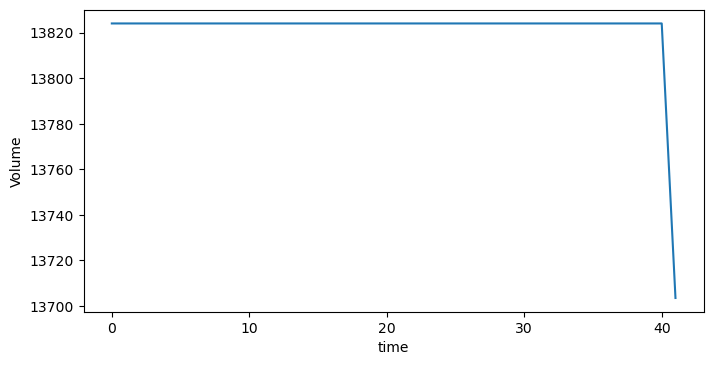

In [29]:
pyplot.figure(figsize=(8,4), dpi=100)
pyplot.plot(data[:,1])
pyplot.xlabel('time')
pyplot.ylabel('Volume')

How can you decide whether your run is equilibrated and are ready to start collecting data?  

<div class=warn>If you still see a systematic change in the volume or the energy, thus not yet reached the phase where these quantities fluctuate around an average value, you need to continue the simulation a bit longer! Execute the command ```hoomd.run(1000)``` again until you're satisfied the system reached equilibrium.</div>

### The production run
To be able to analyse data, you will need to collect configurations from the production run. 

<div class=warn> Create a python ```for``` loop to repeat the following sequence: propagate the MD simulation then save a configuration for later analisys. The command below should be included to save this configurations in a file, so they are available later as well, just in case. (Change the filename!)</div>

In [31]:
xyz_filename="myxyz_filename.xyz"
current_config = save_config(system) # to save the current state of the system after the hoomd.run
ase.io.write(xyz_filename, current_config, append=True) # save the latest configuration into the xyz file. 

**Tips on handling the ASE atoms object**   
Below are a couple of examples how to extract information from the atoms object. For the analisys you will need the e.g. the positions of the atoms and the size of the corresponding simulation box!

In [32]:
at_configuration=ase.io.read(xyz_filename,index=":") # read all atoms objects from the file
# at_configuration now contains a list of configurations. The [-1] refers to suing the latest one among these.
box=at_configuration[-1].get_cell() # simulation box parameters (3*3 matrix)
vol=at_configuration[-1].get_volume() # volume of the simulation box
pos=at_configuration[-1].get_positions() # atomic coordinates
N=len(at_configuration[-1]) # number of atoms
at_type=at_configuration[-1].get_chemical_symbols() # atom_type of each atom
print("box length of last configuration is", box[0,0])

box length of last configuration is 23.725043040527655


# 7. Compute the solvation shell 

<div class=warn> Whether you would opt for the "direct" method or the pair correlation function-based approach (see the "M15_Experimental_Protocol.pdf" document on Moodle), you need to compute the ions-solvent particles pair correlation function(S) in order to identify the cutoff radius. To this end, you can use the ```py_rdf``` function we have used in the CH273 CW_1Key.ipynb computational workshop. However, in this case we need the pair correlation function between cations and solvent particles (p_cs) and the pair correlation function between the anions and the solvent particles (p_as). Modify the code accordingly.
</div>

<div class=warn>
    
* Compute p_cs and p_as. Plot the results on the same graph and identif the cutoff radii for the solvation sheel of cations and anions.
    
* Calculate the extent of the solvation shell for cations and anions
    
* Investigate the changes in the solvation shells observed upon the modification of a simulation parameter of your choosing. For instance, you might want to explore the impact of temperature. In that case, you will have to set up a few different MD simulations at different temperatures, compute the solvation shells for each one of them and collect your results. Varying the pressure, the strength of the LJ interaction between ions and solvent or even the size of the ions are all valid alternatives.
</div>

In [54]:
p_traj

pytraj.Trajectory, 42 frames: 
Size: 0.001572 (GB)
<Topology: 1674 atoms, 1 residues, 0 mols, PBC with box type = ortho>
           

In [68]:
dist = pt.distance(p_traj, '@1 @2')
len(dist)

42